In [1]:
import pandas as pd
import numpy as np
import mysql.connector as sql

In [2]:
class Models:
    def __init__(self, query):
        self.query = query
        self.conn = sql.connect(
                        host = "localhost",
                        user="root",
                        passwd = "",
                        database = "db_ta_1811501327"
                    )
        self.curr = self.conn.cursor()
        
    def select(self):
        self.curr.execute(self.query)
        row_headers = [x[0] for x in self.curr.description]
        result = self.curr.fetchall()
        
        self.curr.close()
        self.conn.close()
        
        json_data = []
        for data in result:
            json_data.append(dict(zip(row_headers, data)))
            
        return json_data
    
    def query_sql(self, values):
        self.curr.execute(self.query, values)
        self.conn.commit()
        self.curr.close()
    
    def query_sql_multiple(self, values):
        self.curr.executemany(self.query, values)
        self.conn.commit()
        self.curr.close()
        
    def query_deleteAll(self):
        self.curr.execute(self.query)
        self.conn.commit()

In [3]:
class MultiNaiveBayes():
    def __init__(self, alpha=1.0):
        self.prior = None
        self.jumlah_kata = None
        self.total_kata = None
        self.likelihood_kata = None
        self.alpha = alpha
        
    def fit(self, x, y):
        '''
        Latih fitur dan label
        Menghitung hal-hal berikut :
            prior : Menghitung probabilitas banyaknya kelas c terhadap jumlah seluruh kelas dalam dokumen
            jumlah_kata : Menghitung jumlah kata yang muncul dalam dokumen pada kelas c terhadap kata unik
            likelihood_kata : likelihood dari setiap kata terhadap kelas c || P(Xi|y) = P(w1|y) * P(w2|y) ... * P(wn|y)
        '''
        jumlah_sample = x.shape[0]

        # Menghitung prior
        classes = np.unique(y)

        x_kelas = []
        for c in classes:
            x_kelas.append(x[y == c])

        x_per_kelas = np.array(x_kelas, dtype=object)
        print(x_per_kelas)

        # x_per_class = np.array([x[y == c] for c in classes], dtype=object)
        # print(x_per_class)

        prior = []
        jumlah_kata = []
        for x_kelas in x_per_kelas:
            prior.append(len(x_kelas) / jumlah_sample)
            jumlah_kata.append(x_kelas.sum(axis=0) + self.alpha)    # Laplace Smoothing dengan menambahkan alpha bernilai 1
        self.prior = np.array(prior)
        self.jumlah_kata = np.array(jumlah_kata)

        # self.prior = np.array([len(x_class) / jumlah_sample for x_class in x_per_kelas])
        print('prior : '+str(np.array([len(x_class) / jumlah_sample for x_class in x_per_kelas])))
        
        # Menghitung likelihood untuk setiap kata (likelihood_kata)
        # self.jumlah_kata = np.array([sub_arr.sum(axis=0) for sub_arr in x_per_kelas]) + self.alpha
        print('jumlah_kata = '+str(np.array([sub_arr.sum(axis=0) for sub_arr in x_per_kelas]))+' + '+str(self.alpha))
        self.total_kata = self.jumlah_kata.sum(axis=1).reshape(-1, 1)   # Menjumlahkan seluruh jumlah_kata
        self.likelihood_kata = self.jumlah_kata / self.total_kata       # Menghitung nilai likelihood || P(w1|y), ..., P(wn|y)
        print('likelihood_kata = '+str(self.jumlah_kata)+' / '+str(self.total_kata))
        
        return self
    
    def _get_class_numerators(self, x):
        '''
        Calculate for each class, the likelihood that an entire message conditional
        on the message belonging to a particular class (real or fake)

        Menghitung setiap kelas, likelihood seluruh teks kondisional pada teks bergantung pada kelas c (positif atau negatif)
        Menghitung hal-hal berikut:
            kata_muncul : kemunculan kata pada x_test
            likelihood_kata : likelihood dari setiap kata terhadap kelas c || P(Xi|y) = P(w1|y) * P(w2|y) ... * P(wn|y)
            likelihood_kata_kini : likelihood dari setiap kata terhadap kelas c yang sedang berlangsung dalam iterasi
            likelihood_teks : likelihood dari seluruh teks terhadap kelas c || P(x|y) = P(Xi|y)
            class_numerators : Perhitungan posterior untuk setiap kelas c
        '''
        n, m = x.shape[0], self.prior.shape[0]
        print('n, m: ',n, m)
        
        class_numerators = np.zeros(shape=(n, m))
        print('class_numerator = ', class_numerators)
        for i, kata in enumerate(x):
            print(i)
            print('kata x_test: ', kata)
            
            kata_muncul = kata.astype(bool)     # Mengubah value kata menjadi boolean
            print('kata_muncul : ', kata_muncul)
            print('kata[kata_muncul]', kata[kata_muncul])
            print('likelihood_kata[:, kata_muncul] :', self.likelihood_kata[:, kata_muncul])
            likelihood_kata_kini = self.likelihood_kata[:, kata_muncul] ** kata[kata_muncul]    # Mengambil likelihood_kata dari kata_muncul
            print('likelihood_kata_kini = '+str(self.likelihood_kata[:, kata_muncul])+' ** '+str(kata[kata_muncul]))
            print('likelihood_kata_kini = ', likelihood_kata_kini)
            likelihood_teks = (likelihood_kata_kini).prod(axis=1)   # Mengalikan seluruh nilai dalam likelihood_kata_kini
            print('likelihood_teks = ', likelihood_kata_kini.prod(axis=1))
            class_numerators[i] = likelihood_teks * self.prior      # Mengalikan likelihood dengan prior (posterior) || P(x|y) = P(y) * P(Xi|y)
            print('class_numerators['+str(i)+'] = '+str(likelihood_teks)+' * '+str(self.prior))
            print('class_numerators = ', class_numerators)
        
        return class_numerators
    
    def _normalized_conditional_probs(self, class_numerators):
        '''
        Conditional probabilities = class_numerators / normalize_term
        '''
        # normalize term is the likelihood of an entire message (addition of all words in a row)
        # normalize term merupakan likelihood dari seluruh teks (penambahan dari seluruh kata dalam satu baris) || P(x)
        normalize_term = class_numerators.sum(axis=1).reshape(-1,1)
        print('normalize_term', normalize_term)
        conditional_probs = class_numerators / normalize_term
        print('conditional_probs = '+str(class_numerators)+' / '+str(normalize_term))
        assert(conditional_probs.sum(axis=1) - 1 < 0.001).all(), 'rows should sum to 1'
        
        return conditional_probs
    
    def predict_proba(self, x):
        '''
        Return the probabilities for each class (fake or real)
        Return probabilitas dari setiap kelas (positif atau negatif)
        '''
        class_numerators = self._get_class_numerators(x)
        conditional_probs = self._normalized_conditional_probs(class_numerators)
        print('conditional_probs = ', conditional_probs)
        
        return conditional_probs
    

    def predict(self, x):
        '''
        Return the answer with the highest probability (argmax)
        Return hasil nilai dengan probabilitas tertinggi (argmax)
        '''
        return self.predict_proba(x).argmax(axis=1)

In [69]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

In [56]:
# Data Training
list_text_training = []
list_label_training = []

instance_model = Models('SELECT clean_text, label FROM tbl_data_train')
data_train = instance_model.select()

for i in range(len(data_train)):
    list_text_training.append(data_train[i]['clean_text'])
    list_label_training.append(data_train[i]['label'])

# Data Testing
list_text_testing = []
list_label_testing = []

instance_model = Models('SELECT clean_text, label FROM tbl_data_test')
data_test = instance_model.select()

for i in range(len(data_test)):
    list_text_testing.append(data_test[i]['clean_text'])
    list_label_testing.append(data_test[i]['label'])

In [9]:
teks_latih = [
    'borobudur naik atas batal masuk lihat tiket naik uang tabung boros',   #negatif
    'tolak tiket naik borobudur catat', #negatif
    'tiket masuk fasilitas utama hilang harga tiket naik borobudur',    #negatif
    'tiket naik gapapa itu tiket naik candi masuk komplek candi jangkau kalang poin plus candi borobudur sakral umat hindu',    #positif
    'tuju tiket naik candi borobudur mahalin jaga suci ibadah umat budha'   #positif
]

label_latih = [
    'negatif',
    'negatif',
    'negatif',
    'positif',
    'positif'
]

# P(positif) = 2/5  P(negatif) = 3/5
# P(positif) = 0.4  P(negatif) = 0.6

teks_uji = [
    'harga tiket masuk candi borobudur bangun dasar ide'
]

label_uji = [
    'negatif'
]

In [57]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(list_text_training).toarray()
X_test = vectorizer.transform(list_text_testing).toarray()

vocab = vectorizer.get_feature_names_out()

labelEncoder = LabelEncoder()
y_train = labelEncoder.fit_transform(list_label_training).ravel()
y_test = labelEncoder.transform(list_label_testing).ravel()

In [93]:
if (len(labelEncoder.classes_) > 2):
    print("a")
else:
    print("b")

a


In [59]:
y_test

array([0, 1, 0, 0, 2, 2, 1, 1, 1, 0, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 1,
       0, 0, 1, 2, 2, 2, 1, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2,
       0, 2, 0, 2, 2, 2, 0, 1, 1, 2, 0, 0])

In [60]:
model = MultiNaiveBayes()
model.fit(X_train, y_train)

[array([[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]], dtype=int64)
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)]
prior : [0.43636364 0.22727273 0.33636364]
jumlah_kata = [[1 0 1 ... 0 0 1]
 [1 1 0 ... 0 0 0]
 [0 0 0 ... 1 1 0]] + 1.0
likelihood_kata = [[2. 1. 2. ... 1. 1. 2.]
 [2. 2. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 2. 2. 1.]] / [[2434.]
 [1579.]
 [2271.]]


In [61]:
y_pred = model.predict(X_test)
y_pred

n, m:  56 3
class_numerator =  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
0
kata x_test:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 

array([0, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2,
       0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2], dtype=int64)

In [13]:
df = pd.DataFrame(X_train, columns=vocab)

In [16]:
vocab

array(['atas', 'batal', 'borobudur', 'boros', 'budha', 'candi', 'catat',
       'fasilitas', 'gapapa', 'harga', 'hilang', 'hindu', 'ibadah', 'itu',
       'jaga', 'jangkau', 'kalang', 'komplek', 'lihat', 'mahalin',
       'masuk', 'naik', 'plus', 'poin', 'sakral', 'suci', 'tabung',
       'tiket', 'tolak', 'tuju', 'uang', 'umat', 'utama'], dtype=object)

In [17]:
model.__dict__

{'prior': array([0.6, 0.4]),
 'jumlah_kata': array([[2., 2., 4., 2., 1., 1., 2., 2., 1., 2., 2., 1., 1., 1., 1., 1.,
         1., 1., 2., 1., 3., 5., 1., 1., 1., 1., 2., 5., 2., 1., 2., 1.,
         2.],
        [1., 1., 3., 1., 2., 5., 1., 1., 2., 1., 1., 2., 2., 2., 2., 2.,
         2., 2., 1., 2., 2., 4., 2., 2., 2., 2., 1., 4., 1., 2., 1., 3.,
         1.]]),
 'total_kata': array([[58.],
        [63.]]),
 'likelihood_kata': array([[0.03448276, 0.03448276, 0.06896552, 0.03448276, 0.01724138,
         0.01724138, 0.03448276, 0.03448276, 0.01724138, 0.03448276,
         0.03448276, 0.01724138, 0.01724138, 0.01724138, 0.01724138,
         0.01724138, 0.01724138, 0.01724138, 0.03448276, 0.01724138,
         0.05172414, 0.0862069 , 0.01724138, 0.01724138, 0.01724138,
         0.01724138, 0.03448276, 0.0862069 , 0.03448276, 0.01724138,
         0.03448276, 0.01724138, 0.03448276],
        [0.01587302, 0.01587302, 0.04761905, 0.01587302, 0.03174603,
         0.07936508, 0.01587302, 0.01587

In [ ]:
true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test, y_pred, labels=['0', '1', '2']).ravel()

akurasi = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
presisi = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)

print('True Positif : ', true_pos)
print('False Positif : ', false_pos)
print('False Negatif : ', false_neg)
print('True Negatif : ', true_neg)

print('akurasi : ', akurasi)
print('presisi : ', presisi)
print('recall : ', recall)

In [ ]:
ml_cm = multilabel_confusion_matrix(y_test, y_pred)
ml_cm

In [62]:
conf_mat = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, zero_division=True, target_names=labelEncoder.classes_)
print(cr)

              precision    recall  f1-score   support

     negatif       0.56      0.79      0.66        24
      netral       0.67      0.15      0.25        13
     positif       0.53      0.53      0.53        19

    accuracy                           0.55        56
   macro avg       0.58      0.49      0.48        56
weighted avg       0.57      0.55      0.52        56



In [76]:
conf_mat

array([[19,  0,  5],
       [ 7,  2,  4],
       [ 8,  1, 10]], dtype=int64)

In [77]:
TNeg = conf_mat[0][0]
FNeg1 = conf_mat[0][1]
FNeg2 = conf_mat[0][2]
FNet1 = conf_mat[1][0]
TNet = conf_mat[1][1]
FNet2 = conf_mat[1][2]
FPos1 = conf_mat[2][0]
FPos2 = conf_mat[2][1]
TPos = conf_mat[2][2]

In [63]:
cm_df = pd.DataFrame(conf_mat,
                     index = ['negatif', 'netral', 'positif'], 
                     columns = ['negatif', 'netral', 'positif'])

In [64]:
cm_df

,negatif,netral,positif
negatif,19,0,5
netral,7,2,4
positif,8,1,10


In [65]:
#Plotting the confusion matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

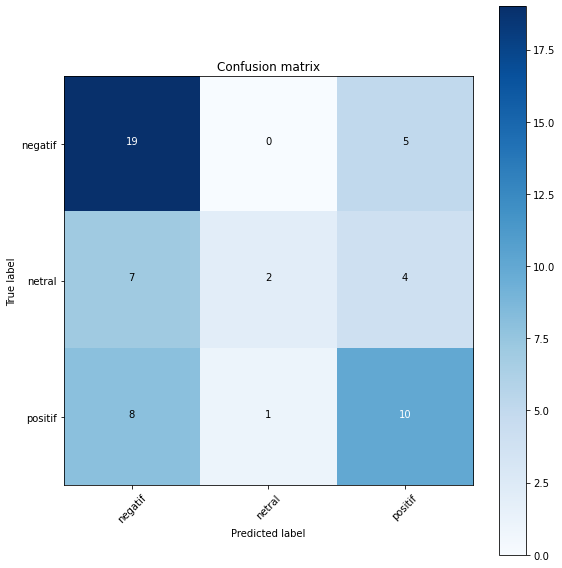

In [66]:
plot_confusion_matrix(conf_mat, classes=labelEncoder.classes_)